# Loading dependencies

In [1]:
###Reyes, Marcus Group 7

###CoE 197Z Project 1.1

import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,BatchNormalization
from keras import regularizers
from keras.optimizers import adam,sgd
from keras import optimizers

import numpy as np
from numpy import genfromtxt

from sklearn import preprocessing

import matplotlib.pyplot as plt

import string

from sixfunctions import load_train, load_x_test, clean_data_with_mean

Using TensorFlow backend.


In [3]:
                  #[reason] / dup == duplicate
                  #unique      #dup of loc, numerous     #messy numerous
do_not_include = ['wpt_name', 'subvillage',             'scheme_name',

                 #uniform value     #Duplicate of payment type   #Dup of quantity
                 'recorded_by',     'payment',                  'quantity_group',
                 
                 #dup of wtptype less data      #dup of source  #dup of extr_type_group
                 'waterpoint_type_group',       'source_type',  'extraction_type',      'extraction_type_group',
                 
                 #enc in regcode
                 'region']

#These are sort of ordinal data
do_not_one_hot = ['id','gps_height','date_recorded','longitude','latitude','population','amount_tsh']

clean_up = ['population','amount_tsh']

#Tentatively do not include.
do_not_include_tent = ['funder','installer','ward','lga']

#Don't know what it means 
do_not_include_temp = ['num_private']

x, train_col,y = load_train("train_set_values.csv","train_set_labels.csv", do_not_include, do_not_one_hot, clean_up, do_not_include_tent, do_not_include_temp)


###Model

hidden = 1024
dropout = 0.4

(trash, input_dim) = x.shape

activation = 'relu'

model = Sequential()


model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))

model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))

model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))


model.add(Dense(3,input_dim = hidden))
model.add(Activation('softmax'))

#model.summary

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


max_score = -1
iter_of_max = 0,0
train_plot = []
val_plot = []
x_axis = []

#Save the weights for k-fold validation
model.save_weights('model.h5')

amount = 120
k_folds = 5

###When i use k_folds instead of 10 for the np.zeros initialization it acts up
val_plot = np.zeros((k_folds,amount))
train_plot = np.zeros((k_folds,amount))
test_plot = np.zeros((k_folds,amount)) 
x_axis = np.zeros((k_folds,amount))
total = int(x.shape[0])
for j in range(k_folds):

    whole = np.arange(0,total)
    test_range = np.arange((j)*(total/k_folds), (j)*(total/k_folds)+(total/k_folds),dtype = 'int')
    
    train_range = np.delete(whole, test_range)
    
    
    #K-fold validation setup
    x_train = x[train_range,:]
    x_pretest = x[test_range,:]
    y_train = y[train_range,:]
    y_pretest = y[test_range,:]
    
    for i in range(amount):

        history = model.fit(x_train, y_train, epochs = 1, batch_size = 4096*16, verbose = 0)
        score = model.evaluate(x_pretest, y_pretest, batch_size = 512, verbose = 0)

        if  float(100 * score[1]) > float(max_score):
            max_score = float(100 * score[1])
            iter_of_max = i,j
        if i%10 == 0:
            print("----------",i,"-",j,"-----------")
            print("Test accuracy: ", (100.0 * score[1]))
            print("Maxscore: ", max_score, "at", iter_of_max,"epoch-kthfold")
        
        #for the plot
        x_axis[j,i] = i
        test_plot[j,i] = (score[1])
        train_plot[j,i] = np.array(history.history['acc'])

        

    if j == k_folds - 1:
        break
    model.load_weights('model.h5')
    print("Reloading Model")
    
print("Done evaluating performance")

About to clean up
About to clean up


C:\Users\Marcus\197_proj1\CoE197Z\sixfunctions.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_recorded'][i] = int(data['date_recorded'][i].replace("-","")[2:6])


Expanded basin Change 23 32
Expanded region_code Change 32 59
Expanded district_code Change 59 79
Expanded public_meeting Change 79 81
Expanded scheme_management Change 81 93
Expanded permit Change 93 95
Expanded construction_year Change 95 150
Expanded extraction_type_class Change 150 157
Expanded management Change 157 169
Expanded management_group Change 169 174
Expanded payment_type Change 174 181
Expanded water_quality Change 181 189
Expanded quality_group Change 189 195
Expanded quantity Change 195 200
Expanded source Change 200 210
Expanded source_class Change 210 213
Expanded waterpoint_type Change 213 220


W1011 12:10:32.909938  6004 deprecation_wrapper.py:119] From c:\users\marcus\anaconda3\envs\coe197z\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1011 12:10:32.923902  6004 deprecation_wrapper.py:119] From c:\users\marcus\anaconda3\envs\coe197z\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1011 12:10:32.927891  6004 deprecation_wrapper.py:119] From c:\users\marcus\anaconda3\envs\coe197z\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1011 12:10:33.006728  6004 deprecation_wrapper.py:119] From c:\users\marcus\anaconda3\envs\coe197z\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default 

---------- 0 - 0 -----------
Test accuracy:  54.57912457109701
Maxscore:  54.57912457109701 at (0, 0) epoch-kthfold
---------- 10 - 0 -----------
Test accuracy:  69.57912458715214
Maxscore:  69.57912458715214 at (10, 0) epoch-kthfold
---------- 20 - 0 -----------
Test accuracy:  74.3434343554757
Maxscore:  74.44444443641687 at (19, 0) epoch-kthfold
---------- 30 - 0 -----------
Test accuracy:  75.43771044172422
Maxscore:  75.43771044172422 at (30, 0) epoch-kthfold
---------- 40 - 0 -----------
Test accuracy:  76.54040404441783
Maxscore:  76.54040404441783 at (40, 0) epoch-kthfold
---------- 50 - 0 -----------
Test accuracy:  77.76094276495654
Maxscore:  77.76094276495654 at (50, 0) epoch-kthfold
---------- 60 - 0 -----------
Test accuracy:  78.31649830847076
Maxscore:  78.35858588266854 at (56, 0) epoch-kthfold
---------- 70 - 0 -----------
Test accuracy:  78.98989898187143
Maxscore:  78.98989898187143 at (70, 0) epoch-kthfold
---------- 80 - 0 -----------
Test accuracy:  79.0656565897

# Plotting the Training Accuracy vs the Test Accuracy

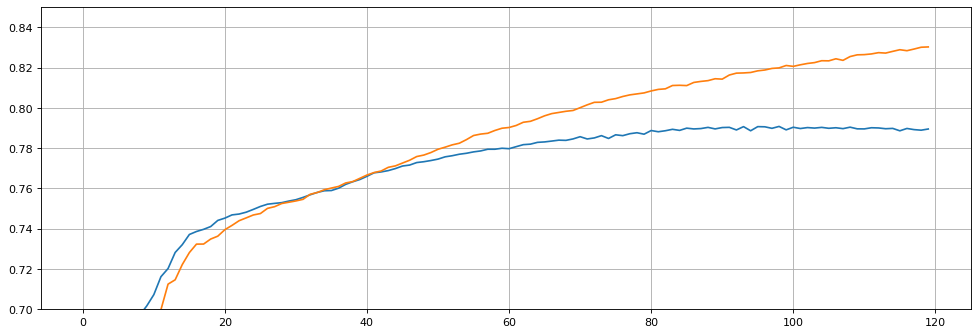

In [17]:

plt.figure(figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([0.70,0.85])
plt.grid(which = 'both')
plt.plot(np.mean(test_plot[0:k_folds,:],axis = 0))
plt.plot(np.mean(train_plot[0:k_folds,:],axis = 0))

plt.draw()
plt.pause(0.001)


In [5]:

#Train one final time on the entire model
history = model.fit(x, y, epochs = 1, batch_size = 4096*16)


#Load the test data
x_test, test_col,data_id = load_x_test("test_set_values.csv",train_col, do_not_include, do_not_one_hot, clean_up, do_not_include_tent, do_not_include_temp)




#Make the predictions
y_pred = model.predict(x_test)
status = np.argmax(y_pred, axis = 1)
status = status.reshape(x_test.shape[0],1)
id = x_test[:,0].reshape(x_test.shape[0],1)
y_pred = np.concatenate((id,status), axis = 1)


#Format the submission
presub_id = pd.DataFrame(data_id)
presub_status = pd.DataFrame(status)
presub_status.replace({0:'functional',1:'functional needs repair',2:'non functional'}, inplace=True)
presubmission = pd.concat([presub_id,presub_status],axis = 1)
presubmission.iloc[:,0] = presubmission.iloc[:,0].astype(int)
presubmission.to_csv("submission_datadriven.csv",header = ["id", "status_group"],index = False)
print("Outputted csv file")

Epoch 1/1
59400/59400 [==============================] - 1s 21us/step - loss: 0.4330 - acc: 0.8218


C:\Users\Marcus\197_proj1\CoE197Z\sixfunctions.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_recorded'][i] = int(data['date_recorded'][i].replace("-","")[2:6])


Expanded basin Change 23 32
Expanded region_code Change 32 58
Expanded district_code Change 58 78
Expanded public_meeting Change 78 80
Expanded scheme_management Change 80 91
Expanded permit Change 91 93
Expanded construction_year Change 93 148
Expanded extraction_type_class Change 148 155
Expanded management Change 155 167
Expanded management_group Change 167 172
Expanded payment_type Change 172 179
Expanded water_quality Change 179 187
Expanded quality_group Change 187 193
Expanded quantity Change 193 198
Expanded source Change 198 208
Expanded source_class Change 208 211
Expanded waterpoint_type Change 211 218
Index(['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude',
       'population', 'basin_Internal', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
       'basin_Lake Tanganyika',
       ...
       'source_class_unknown', 'source_class_nan',
       'waterpoint_type_cattle trough', 'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple